In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import pprint

In [2]:
import at2df

In [3]:
pd.options.display.float_format = '{:.2f}'.format # This doesn't seem to do anything though...
sns.set(rc={"figure.figsize":(7, 5)})
sns.set(font_scale=1.25)

In [4]:
VERBOSE = True
SAVE = True
savedir = 'results'
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight'}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 300}

# Analyze Cryptopolitics survey results

## Import data

In [5]:
at = at2df.get_airtable()

In [6]:
df = at2df.get_table_as_df(at, 'Cryptopolitical Typology Quiz')

In [7]:
# Define relevant columns lists, in order
cols_questions_orig = ['1. Which statement comes closest to your views?', 
                  '2. Which blockchain is the best?','3', '4', '5', '6', '7', '8',
                  '9. In order to grow, the crypto ecosystem should:','10', '11', '12', '13',
                  '14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:',
                  '15', '16. Who should have decision-making power over a blockchain?', '17. I\'m here for...',
                  '18. Do you consider yourself:', '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?']

def rename_col(x):
    if x[0].isdigit():
        return 'Q'+x.split('.')[0]
    else:
        return x

cols_questions = [rename_col(x) for x in cols_questions_orig]
df.rename(columns=rename_col, inplace=True)

cols_results = ['classification', 'politics', 'economics', 'governance', 'maxi']

# To convert back and forth between column names (question text) and question number
n2qDict = {i+1: x for (i, x) in enumerate(cols_questions)}
q2nDict = {x: i+1 for (i, x) in enumerate(cols_questions)}

In [8]:
# Split into questions and faction results DataFrames
df_questions = df[cols_questions]
df_results = df[cols_results]

## Data cleaning

In [9]:
# Replace old version of a response value with updated one
oldVal = "Blockchain and DeFi are predatory technologies that, on balance, will harm most members of people."
newVal = "Blockchain and DeFi are predatory technologies that, on balance, will harm most members of society."
df_questions.loc[:,'Q10'] = df_questions['Q10'].copy().replace(to_replace=oldVal, value=newVal)

/home/notchia/miniconda3/envs/metagov/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [10]:
# Replace old versions of faction values with updated ones
toReplace = {'Governoob': 'Noob', 'Passerby': 'NPC'}
for key, value in toReplace.items():
    for col in cols_results:
        df_results.loc[:,col] = df_results[col].copy().replace(to_replace=key, value=value)

In [11]:
# For reference, list all answers observed for each question
if VERBOSE:
    for col in cols_questions[:-1]:
        print(col)
        for answer in df_questions[col].unique():
            print("\t", answer)

Q1
	 There is no one best blockchain.
	 There is one (layer 1) blockchain that is the best.
	 nan
Q2
	 nan
	 Ethereum
	 Polkadot
	 Bitcoin
	 Solana
	 Cardano
Q3
	 Crypto is mainly an economic technology.
	 Crypto is mainly a political philosophy and/or lifestyle.
	 nan
Q4
	 My goal in crypto is to make as much money as possible.
	 My goal in crypto is to earn a living and/or build my career.
	 My goal in crypto is to create social change and/or disrupt the industry.
	 nan
	 My goal in crypto is to have fun.
Q5
	 Most or all cryptogovernance should be on-chain.
	 However crypto governs itself, it should also be regulated by the government.
	 Crypto does not need (human) governance; let the algorithms run as they were designed.
	 Most or all cryptogovernance should be off-chain.
	 nan
Q6
	 Privacy is nice, but it’s not the most important feature of blockchain and crypto.
	 nan
	 Privacy is the most important feature of blockchain and crypto.
Q7
	 Government regulation of crypto can do so

## Distribution of factions

In [12]:
def plot_pie_faction(col, df, colors=sns.color_palette("Set2")):
    """Plot pie chart for overall faction"""
    
    vals = df_results[col].value_counts()
    
    plt.figure()
    labels = [f"{k} ({v})" for k, v in vals.items()]
    fig = plt.pie(vals, labels=labels, colors=colors, wedgeprops=dict(width=0.5))
    #plt.legend(bbox_to_anchor=(1.4, 1, 1, -0.1), loc='upper left')
    
    # Save
    fname = f'{savedir}/cryptopolitics_faction_{col}'
    plt.savefig(f'{fname}.svg', **kwargs_svg)
    plt.savefig(f'{fname}.png', **kwargs_png)

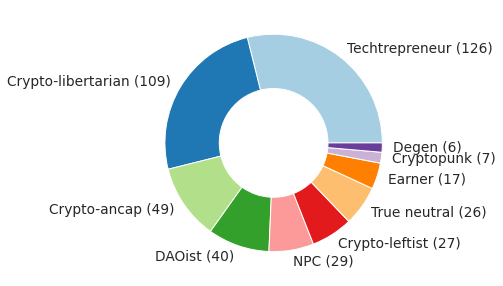

In [13]:
# Pie chart for overall faction
plot_pie_faction('classification', df_results, colors=sns.color_palette("Paired"))

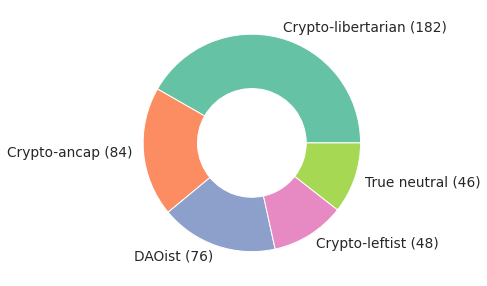

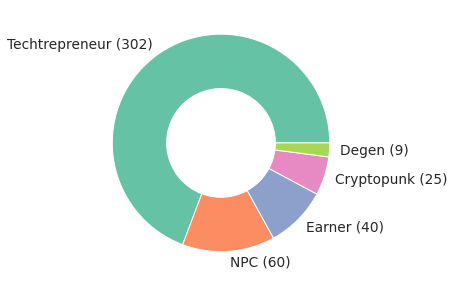

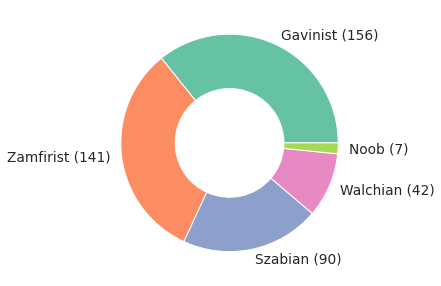

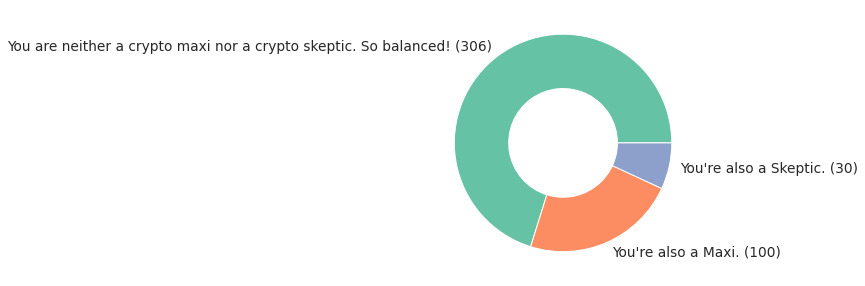

In [14]:
# Pie chart for specific dimensions
for col in cols_results[1:]:
    plot_pie_faction(col, df_results)

## Responses to questions
Reproduce the plots from the [Typeform response page](https://metagov.typeform.com/report/bz9SbjUU/ZY07qRfTs68oypzt)

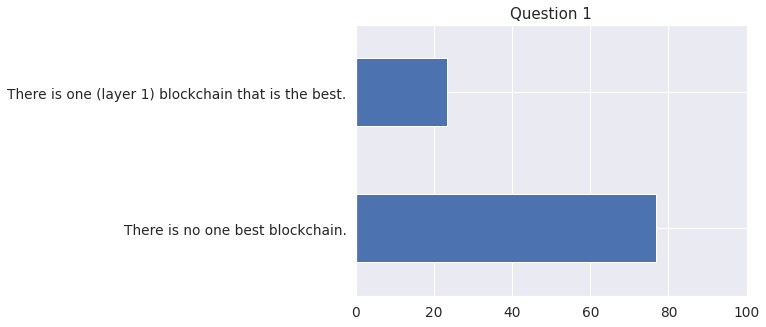

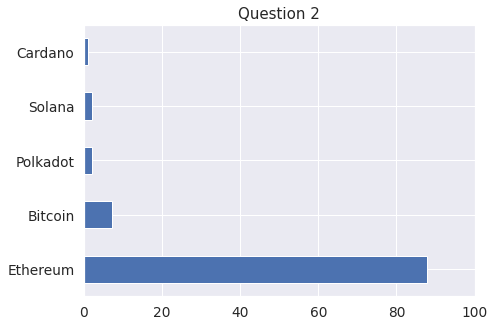

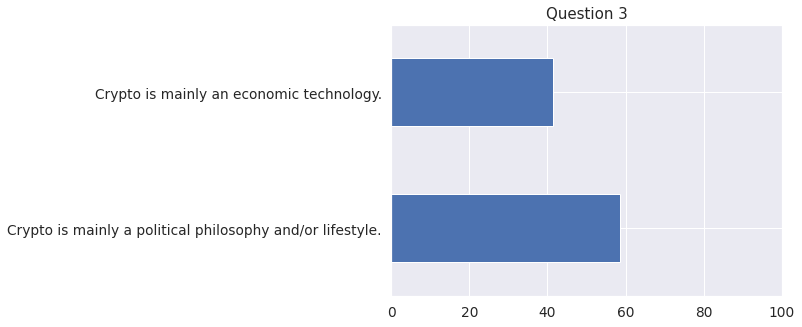

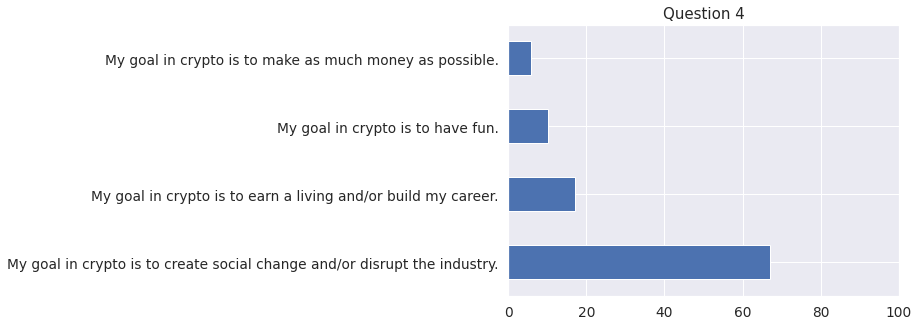

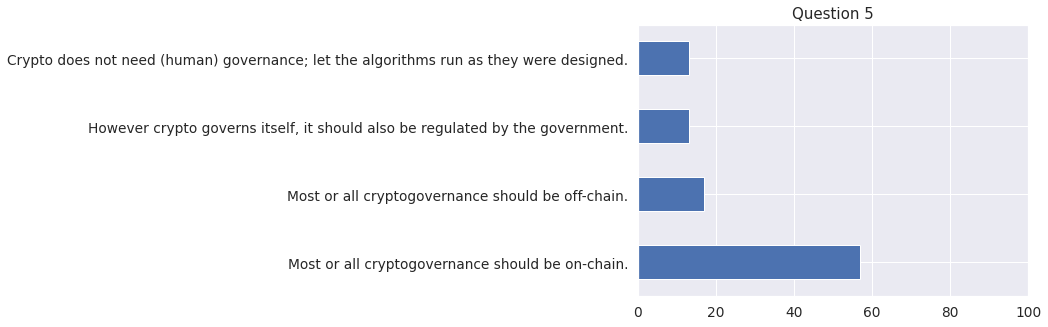

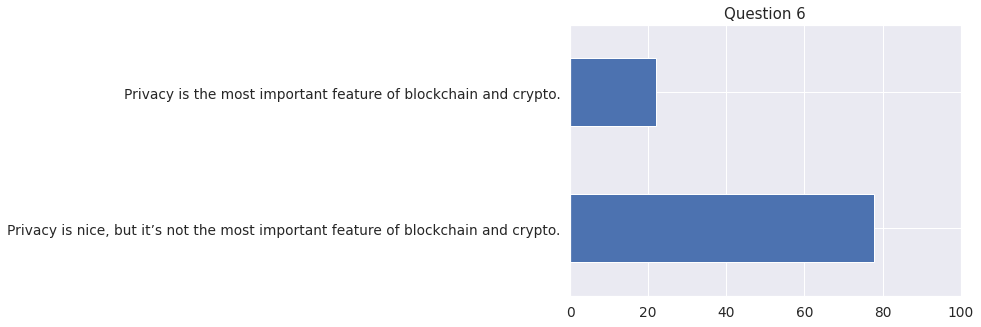

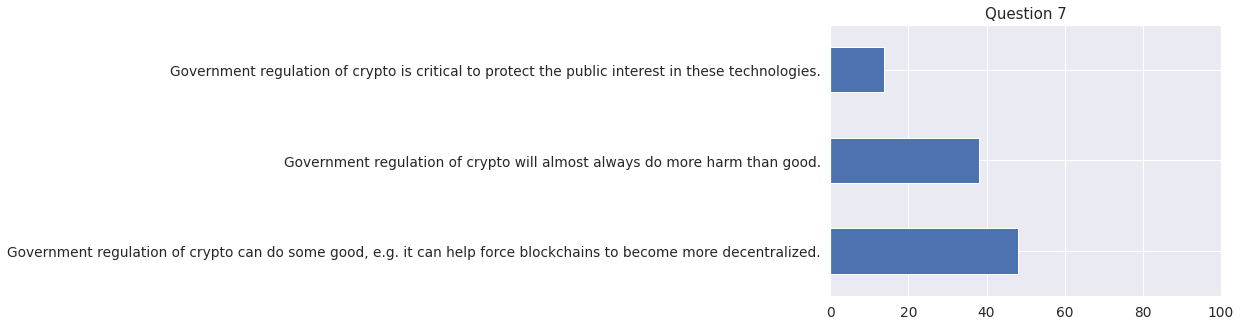

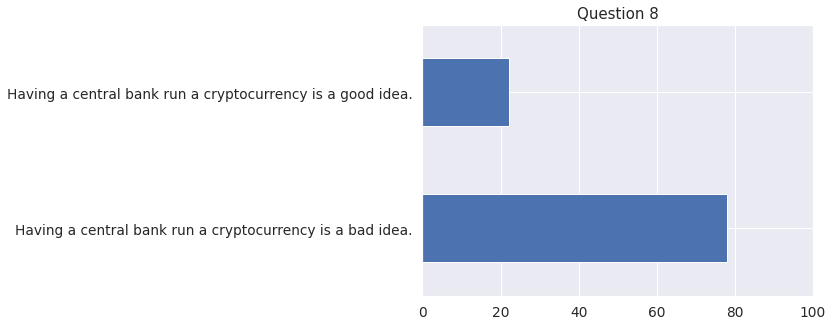

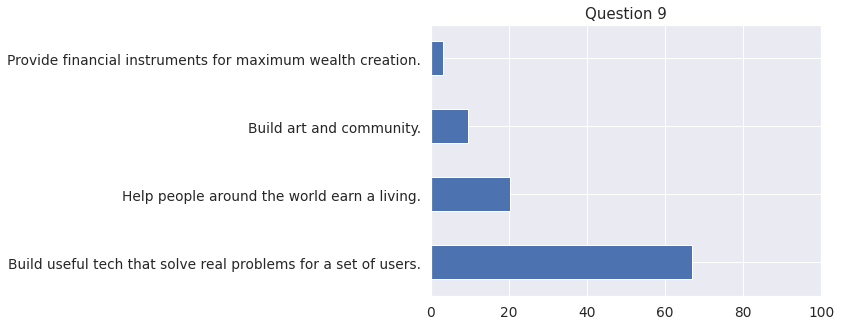

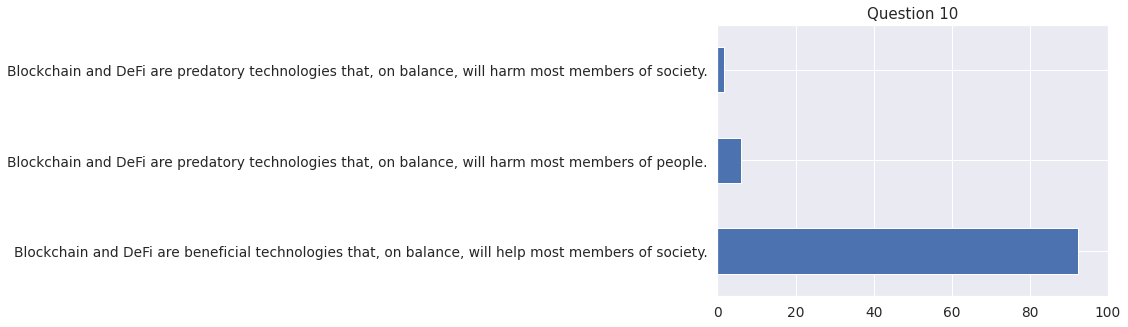

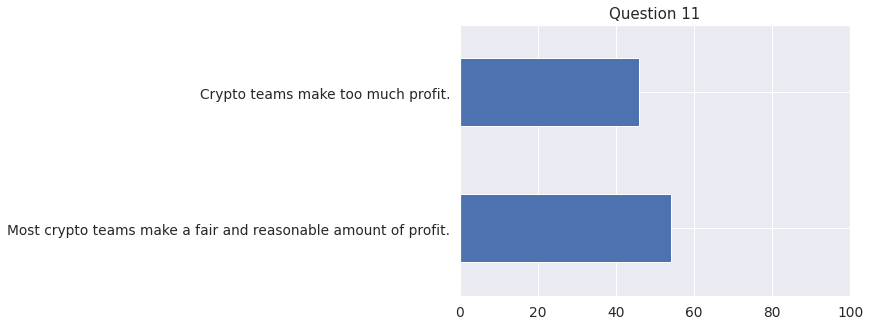

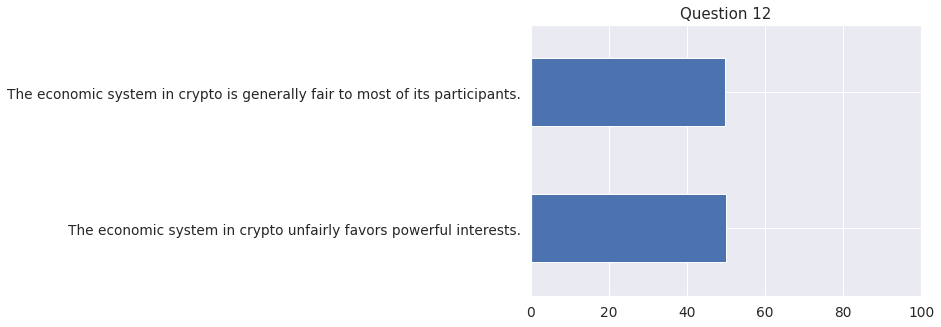

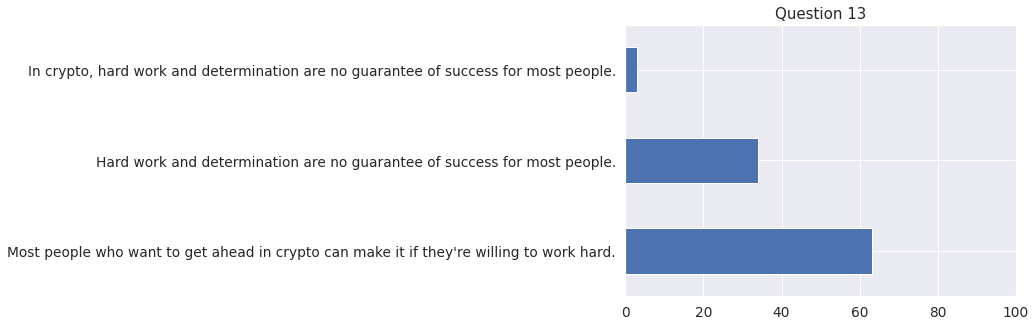

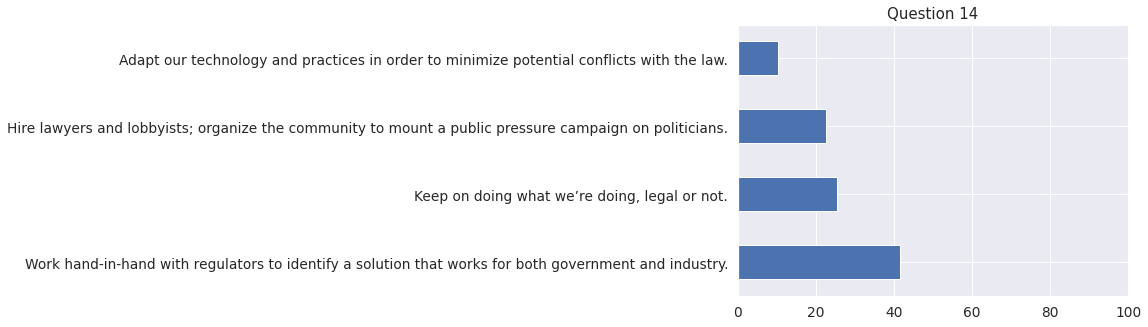

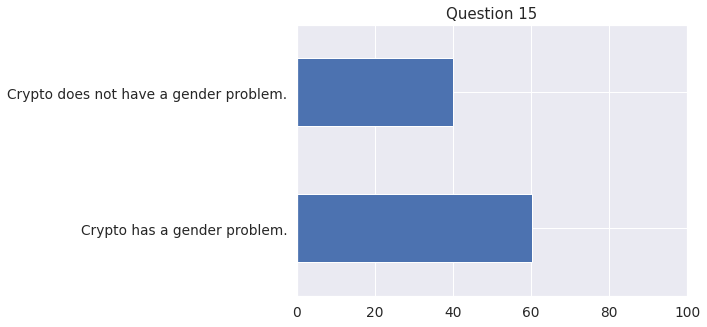

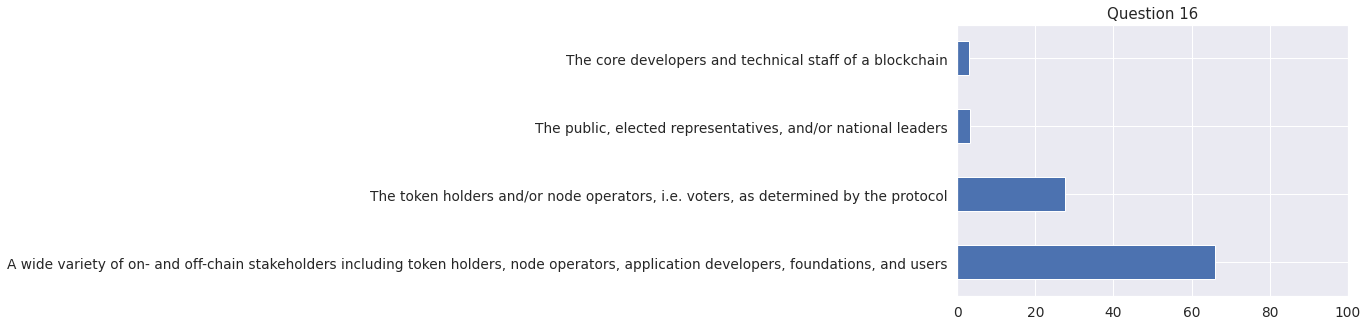

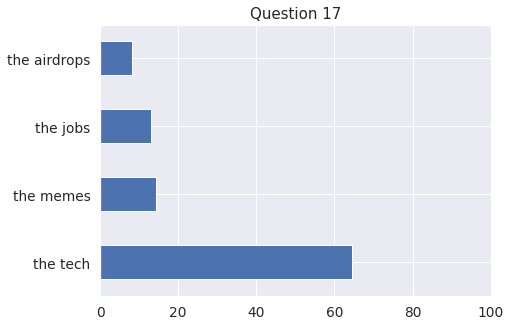

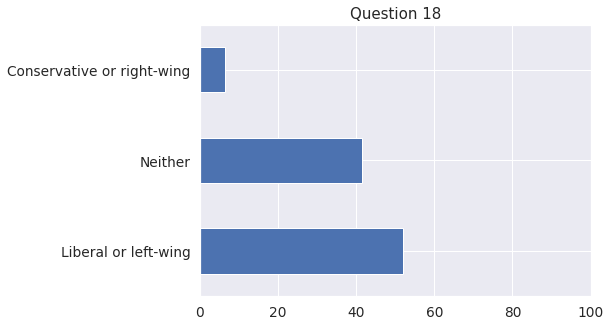

In [15]:
# Plot these differences in responses
for col in cols_questions[:-1]:
    df_tmp = df[col].value_counts(normalize=True)*100

    # Plot
    plt.figure()
    qnum = q2nDict[col]
    ax = df_tmp.plot.barh(title=f"Question {qnum}", xlim=(0,100))
    
    # Save
    fname = f'{savedir}/cryptopolitics_Q{qnum}'
    plt.savefig(f'{fname}.svg', **kwargs_svg)
    plt.savefig(f'{fname}.png', **kwargs_png)

Notes of interest on these, as of 12/20/2021:
- (Q3) A small majority of respondents consider crypto to be mainly a political philosophy/lifestyle, rather than mainly an economic technology.
    - This response was used to choose which of a respondent's political or economic faction was selected as their final classification.
- (Q5, Q16) A majority of respondents believe most or all cryptogovernance should be on-chain; however, most also believe power should be distributed over a wide variety of on- and off-chain stakeholders.
    - Slight friction between these beliefs?
- **(Q7, Q14) Mixed opinions on government regulation of crypto** - most common response is neutral; though most common response is to work hand-in-hand with regulators, a majority of respondents prefer a more neutral or adversarial approach to legal oversight.
- (Q9, Q10) Majority sentiment is that to grow, crypto should build useful tech that solves real problems for a set of users; **large majority believes blockchain and DeFi are beneficial technologies** that, on balance, will help most members of society.
- **(Q11, Q12) Respondents are polarized** on whether crypto teams make a fair and reasonable amount of profit or too much profit, and similarly, whether the economic system in crypto is generally fair to most of its participants or unfairly favors powerful interest.


## Correlation table/heat map
For all pairs of questions, cross-tabulate and calculate Cramer's V for strength of relation

In [16]:
def cramers_v(q1, q2, verbose=False, save=False):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Skip questions with list as response
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index)
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses
    # E.g., Q2 is only answered if a particular answer is given to Q1
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)
    
    ct_norm = pd.crosstab(q1, q2, margins=True, normalize=True)*100
    
    if verbose:
        print(ct_norm)
        #cols = ct_norm.iloc[-1, :-1].sort_values()
        #rows = ct_norm.iloc[:-1, -1].sort_values()
        #plt.figure()
        #rows.plot.bar(color='red', ylim=(0,100))
        #cols.plot.bar(color='blue', xlim=(0,100))
    if save:
        ct_norm.to_csv(f"{savedir}/cryptopolitics_{q1.name}-{q2.name}.csv")
    
    return V

In [17]:
def compute_cramers_v_matrix(df):
    """Compute Cramer's V for each pair of questions"""
    
    cols = list(df.columns)
    nCols = len(cols)
    cramersMatrix = np.zeros((nCols, nCols))
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            # Select only rows for which both questions were answered
            df_tmp = df[pd.notnull(df[c1]) & pd.notnull(df[c2])]
            cramersMatrix[i, j] = cramers_v(df_tmp[c1], df_tmp[c2])
            
    return cramersMatrix

In [18]:
def plot_cramers_v_matrix(df):
    """Plot heatmap of Cramer's V"""
    
    plt.figure(figsize=(8,8))
    fig = sns.heatmap(df, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    fig.xaxis.set_ticks_position("top")
    fig.set_xticklabels(labels=df.columns, rotation=60)
    fig.set_aspect('equal')

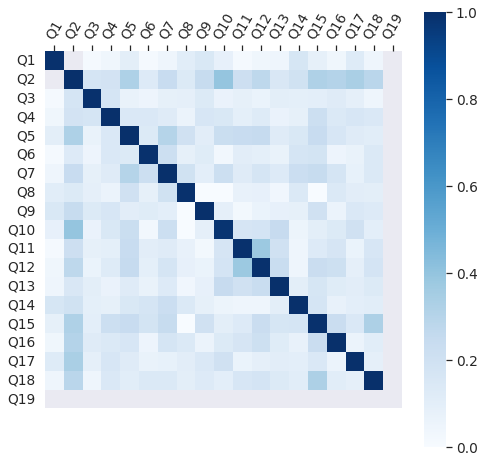

In [19]:
# Correlation matrix for responses to questions
cramersMatrix = compute_cramers_v_matrix(df_questions)
df_cramer = pd.DataFrame(cramersMatrix, index=cols_questions, columns=cols_questions)
plot_cramers_v_matrix(df_cramer)

From a quick glance, it doesn't seem that any responses are highly correlated with any other responses... Note however that there is not any implication of significance here (need p-value).

In [20]:
# Correlation between political faction and economic faction
v = cramers_v(df_results['politics'], df_results['economics'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

economics           Cryptopunk  Degen  Earner   NPC  Techtrepreneur    All
politics                                                                  
Crypto-ancap              1.83   0.46    1.15  1.38           14.45  19.27
Crypto-leftist            0.69   0.00    1.15  1.83            7.34  11.01
Crypto-libertarian        1.38   1.15    4.59  6.42           28.21  41.74
DAOist                    1.15   0.23    0.92  2.98           12.16  17.43
True neutral              0.69   0.23    1.38  1.15            7.11  10.55
All                       5.73   2.06    9.17 13.76           69.27 100.00

Correlation: 0.090


In [21]:
v = cramers_v(df_results['politics'], df_results['governance'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

governance          Gavinist  Noob  Szabian  Walchian  Zamfirist    All
politics                                                               
Crypto-ancap            4.59  0.23    10.09      0.69       3.67  19.27
Crypto-leftist          2.98  0.00     0.69      2.75       4.59  11.01
Crypto-libertarian     17.89  0.69     7.11      2.98      13.07  41.74
DAOist                  7.11  0.00     1.83      2.52       5.96  17.43
True neutral            3.21  0.69     0.92      0.69       5.05  10.55
All                    35.78  1.61    20.64      9.63      32.34 100.00

Correlation: 0.238


In [22]:
v = cramers_v(df_results['economics'], df_results['governance'], verbose=True, save=True)
print(f"\nCorrelation: {v:.3f}")

governance      Gavinist  Noob  Szabian  Walchian  Zamfirist    All
economics                                                          
Cryptopunk          1.61  0.00     2.06      0.46       1.61   5.73
Degen               1.61  0.00     0.23      0.00       0.23   2.06
Earner              3.67  0.23     2.06      0.92       2.29   9.17
NPC                 5.28  1.15     2.06      1.61       3.67  13.76
Techtrepreneur     23.62  0.23    14.22      6.65      24.54  69.27
All                35.78  1.61    20.64      9.63      32.34 100.00

Correlation: 0.142


For politics-economics and economics-governance, these values are also quite small (0 to 1 scale). **This indicates that these pairs of labels may suitably characterize two independent "axes" of belief.**

On inspection of the politics-governance cross-tabulation, **the proportion of crypto-ancap who were Szabians (or vice versa) was higher than for the other faction combinations**. This makes sense given the aversion to centralized governance inherent in both of these definitions.

## Ethereum v. Bitcoin
Are there any differences in responses between people affiliated with these ecosystems?

In [23]:
# Select respondents who included an affiliation with Ethereum or Bitcoin (not mutually exclusive)
optCol = n2qDict[19]
df_tmp = df_questions[pd.notnull(df_questions[optCol])]
df_eth = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Ethereum' in x)].drop(columns=[optCol])
df_btc = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Bitcoin' in x)].drop(columns=[optCol])
print("Number of Ethereum affiliates: ", len(df_eth.index))
print("Number of Bitcoin affiliates:  ", len(df_btc.index))

Number of Ethereum affiliates:  323
Number of Bitcoin affiliates:   91


### Most common responses to each question, for each affiliation

In [24]:
df_eth.rename(columns=q2nDict).mode()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing


In [25]:
df_btc.rename(columns=q2nDict).mode()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither


Differences between these groups are in questions **7 (government regulation)**, **14 (government regulation)**, **15 (gender)**, and **18 (political affiliation)**.

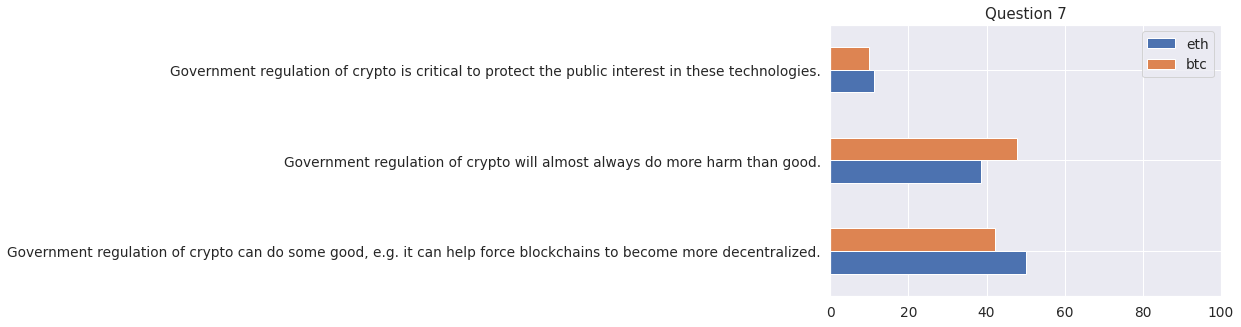

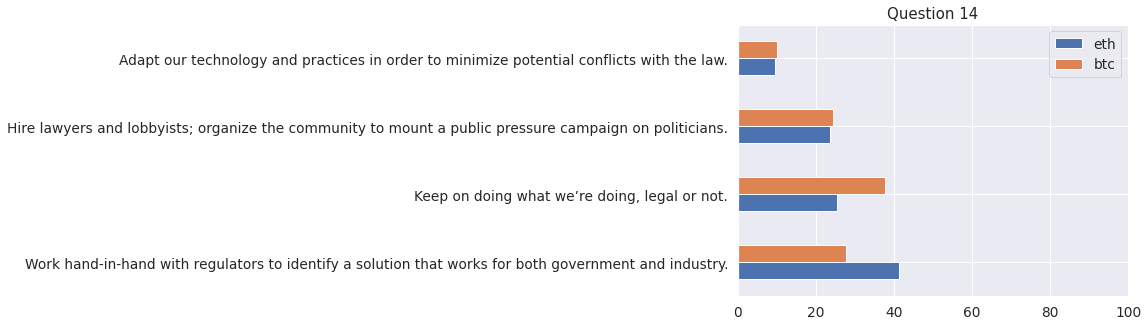

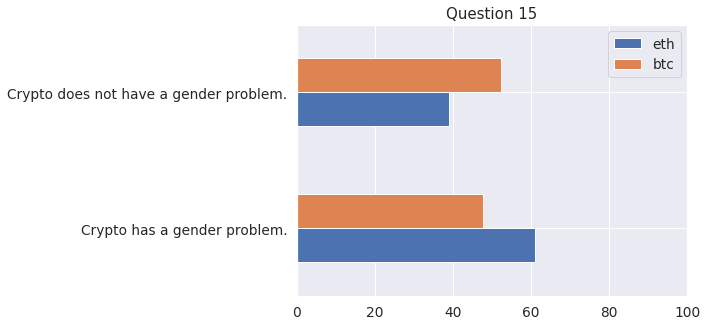

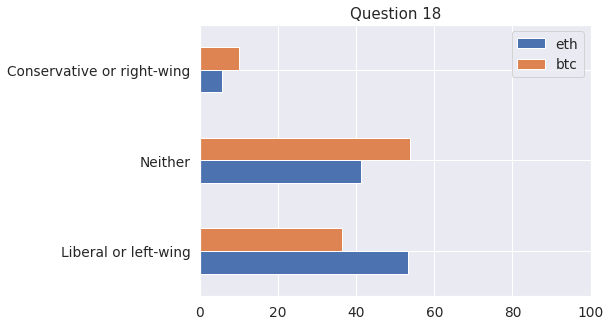

In [26]:
# Plot these differences in responses
for val in [7, 14, 15, 18]:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_tmp[ecosys] = df[n2qDict[val]].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=f"Question {val}", xlim=(0,100))

    fname = f"{savedir}/crytopolitics_btc-v-eth_Q{val}"
    plt.savefig(f"{fname}.png", **kwargs_png)
    plt.savefig(f"{fname}.svg", **kwargs_svg)

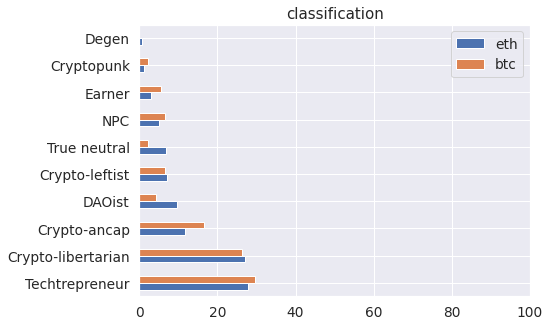

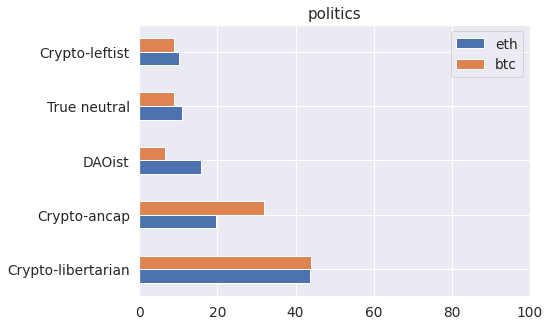

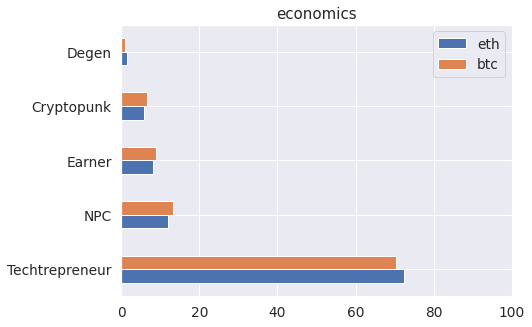

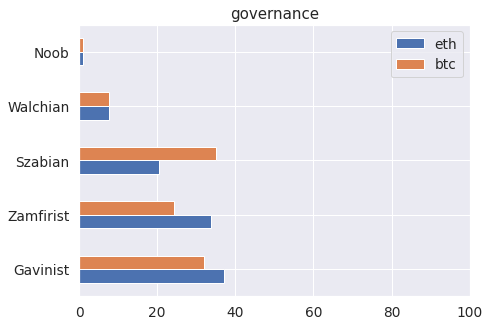

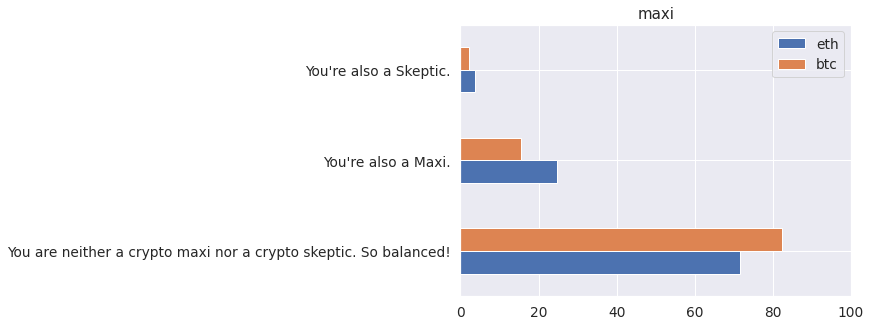

In [27]:
# Plot differences in assigned factions
for col in cols_results:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_r = df_results[df_results.index.isin(df.index)]
        df_tmp[ecosys] = df_r[col].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=col, xlim=(0,100))
    
    fname = f"{savedir}/crytopolitics_btc-v-eth_{col}"
    plt.savefig(f"{fname}.png", **kwargs_png)
    plt.savefig(f"{fname}.svg", **kwargs_svg)

## Clustering
Crypto sentiment: can we identify and describe clusters of responses in a meaningful way?

Notes:
- **Data preprocessing**: two options: encode categorical values as one-hot, or map to ordinal values on -1 to 1 scale where possible. Both of these are implemented below as `allCat` and `mixed`
  
- **Dimensionality reduction**/grouping questions by responses:
  
  - **Generally**: How to interpret? Ideally, expect to find principal components/eigenvectors/axes that correspond to something like the "politics" or "economics" axes Josh defined (or some other belief/value axis not yet identified)
    
  - **PCA**: 
      - Principal components are not interpretable on one-hot encoding. TODO: try multiple correspondence analysis instead?
      - More interpretable for ordinal encoding; could snap to nearest response value to get (near-)orthogonal response vectors?
      - Either way, the variance explained is quite low, so this may not be super helpful.
    
  - **Isomap** (manifold method): embedding is not invertible, so may be difficult to interpret on its own. Choice of distance metric greatly influences resulting map (for categorical data, dice/hamming?; for ordinal data, cosine/cityblock?)
    
  - TODO: try **feature agglomeration**
    
- **Clustering**/grouping responses by questions:
  
  - **Generally**: How many groups to choose (when method allows/required number of clusters to be chosen)? If the clusters correspond to anything like Josh's defined factions, there may be ~4 clusters for ~2 orthgonal "sentiment" axes --> 16 total clusters (e.g., compare w/politics-economics cross-tabulation), but of very different sizes. 
  
  - **Kmeans**: Constraint of equal cluster sizes not suitable for this data. However, Kmodes clusters corresponding to a representative set of answers is nice.
    
  - **Agglomerative clustering**: starts with individual responses and agglomerates responses hierarchically by distance. TODO: map clusters back to response values
    
  - **Affinity propagagion**: has interpretability of "exemplar" sample, but without equal-cluster-sizes restriction of Kmeans

### Preprocessing
- Drop rows with any emtpy vals; drop questions relating to specific ecosystems
- Create two versions of the data:
    - All questions one-hot encoded; shape=(391,49)
    - All but four categorical questions mapped to ordinal values on -1 to 1 scale; shape=(391,29)

In [28]:
# Preprocessing
df_tmp = df_questions.drop(columns=[n2qDict[2], n2qDict[19]])
df_to_cluster = df_tmp[~df_tmp.isnull().any(axis=1)]
cols_questions_clustering = cols_questions
cols_questions_clustering.remove(n2qDict[2])
cols_questions_clustering.remove(n2qDict[19])

In [29]:
# Import ordinal mapping from file
df_map = pd.read_csv('cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        try:
            m = float(row['Mapping'])
        except ValueError:
            m = row['Mapping']
        questionDict[row['Answer']] = m
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2qDict[k]: v for (k, v) in mappingDict.items()}

In [30]:
# Get mapped version of full response DataFrame
df_mapped = df_to_cluster.copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])
    
print(df_mapped.head())

       Q1    Q3 Q4    Q5    Q6    Q7    Q8 Q9   Q10   Q11   Q12   Q13  Q14  \
id                                                                           
256 -1.00  1.00  B  0.50 -1.00  0.00 -1.00  C  1.00 -1.00 -1.00  1.00 1.00   
321  1.00 -1.00  D  0.50 -1.00  0.00 -1.00  B  1.00  1.00 -1.00 -1.00 0.50   
134 -1.00  1.00  D  0.50 -1.00  1.00 -1.00  C  1.00 -1.00 -1.00  1.00 1.00   
408 -1.00 -1.00  C -1.00 -1.00 -1.00 -1.00  C -1.00 -1.00 -1.00 -1.00 1.00   
26  -1.00 -1.00  C  0.50 -1.00  0.00 -1.00  C  1.00 -1.00  1.00  1.00 1.00   

      Q15 Q16 Q17   Q18  
id                       
256 -1.00   C   C -1.00  
321  1.00   B   C -1.00  
134  1.00   B   B  1.00  
408  1.00   B   A -1.00  
26   1.00   B   A -1.00  


In [31]:
# Encode categorical as one-hot and rescale
v = DictVectorizer(sparse=False)
cols_categorical = [n2qDict[x] for x in [4,9,16,17]]
X_categorical = v.fit_transform(df_mapped[cols_categorical].to_dict(orient='records'))
df_categorical = pd.DataFrame(X_categorical, columns=v.get_feature_names_out())
df_categorical = df_categorical.multiply(0.5) # 2*(1/4): ordinal_range*(1/n_possible_responses), assuming both are constant across questions

# Merge with ordinal to create mixed ordinal-categorical data
df_ordinal = df_mapped.drop(columns=cols_categorical)
df_mixed = pd.concat([df_ordinal.reset_index(drop=True), df_categorical], axis=1)
X_mixed = df_mixed.to_numpy()

df_mixed.shape

(391, 29)

In [32]:
# Encode all as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())
df_allCat.shape

(391, 49)

### Dimensionality reduction/group questions by responses

In [33]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    kwargs = {}
    if colors is not None:
        kwargs['color'] = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], **kwargs)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

In [34]:
def compute_and_plot_pca(X, N, labels=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.8, figsize=(12,6))
    plt.ylabel('Component value\n(note: scale for ordinal is different from that of categorical)')
    
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    # Plot
    scatter_plot_combos(X_transformed, min(N, 3), title='PCA')

    return X_transformed, pca

In [35]:
def compute_and_plot_feature_agglomeration(X, N, labels=None, kwargs={}):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(gb.get_group(key), "\n\n")
    
    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Feature Agglomeration ({kwargs})')

    return X_transformed, fa

In [36]:
def compute_and_plot_isomap(X, N, metric='cosine'):
    """Compute and plot isomap transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    iso = Isomap(n_components=N, metric=metric) #cosine, cityblock, hamming, dice
    X_transformed = iso.fit_transform(X)
    
    # Display some results
    for component in iso.kernel_pca_.eigenvectors_[:N]:
        print("[", ', '.join([f"{x:.2f}" for x in component]), "]")

    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Isomap ({metric})')

    return X_transformed, iso

Total variance explained: 98.8%


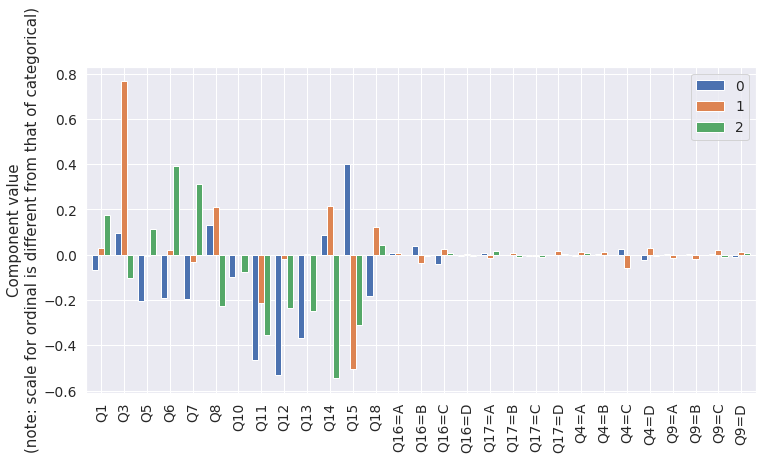

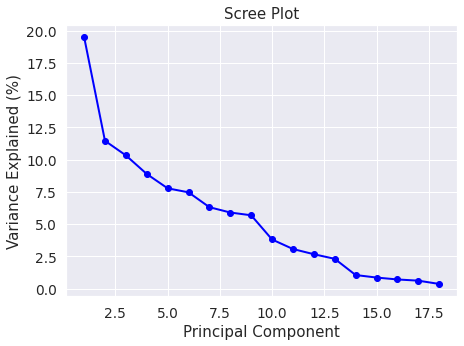

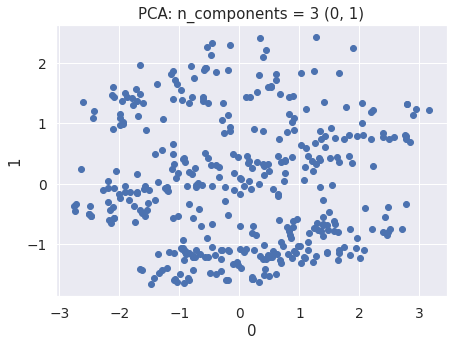

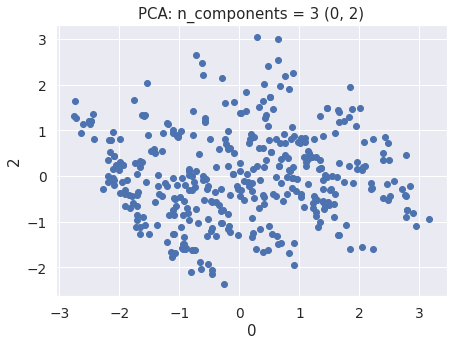

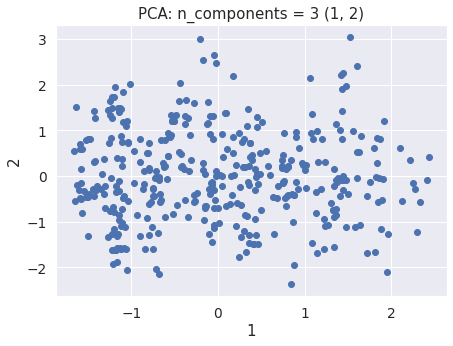

In [37]:
# PCA on mostly-ordinal data
# Choose n_PCA based on number of questions
# Displays only first three vectors for convenience
n_PCA = 18
X_pca_mixed, pca_result = compute_and_plot_pca(X_mixed, n_PCA, labels=list(df_mixed.columns))

In [38]:
kwargs_fa_allCat = {'affinity': 'manhattan', 'linkage': 'complete'}
kwargs_fa_mixed = {'affinity': 'cosine', 'linkage': 'single'}

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
14                   Q15=Crypto has a gender problem.        0
15  Q16=A wide variety of on- and off-chain stakeh...        0
24                           Q18=Liberal or left-wing        0
26                Q1=There is no one best blockchain.        0
28  Q3=Crypto is mainly a political philosophy and...        0
30  Q4=My goal in crypto is to create social chang...        0
38  Q6=Privacy is nice, but it’s not the most impo...        0
40  Q7=Government regulation of crypto can do some...        0
43  Q8=Having a central bank run a cryptocurrency ...        0 


                                             question  feature
1   Q10=Blockchain and DeFi are predatory technolo...        1
7   Q13=In crypto, hard work and determination are...        1
9   Q14=Adapt our technology and practices in orde...        1
10  Q14=Hire lawyers and lobbyists; organize the c..

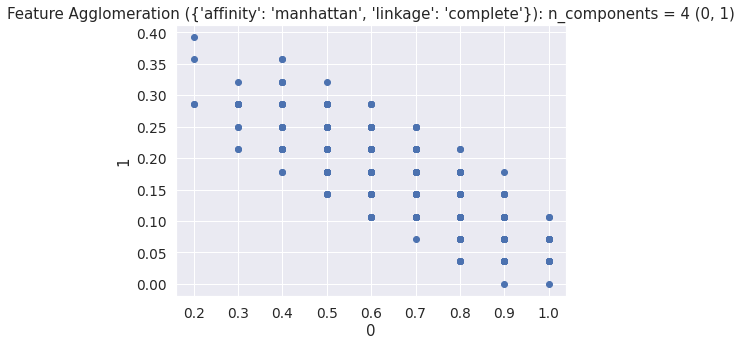

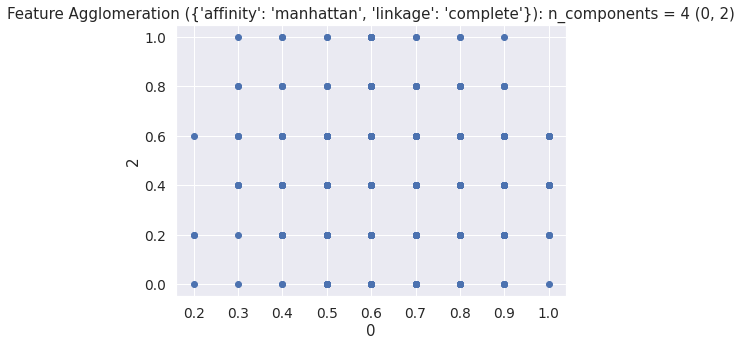

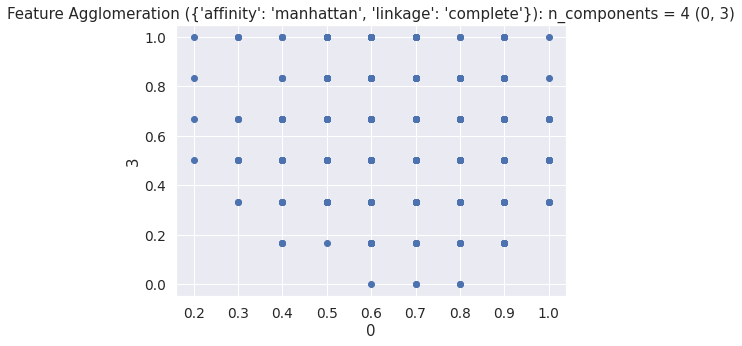

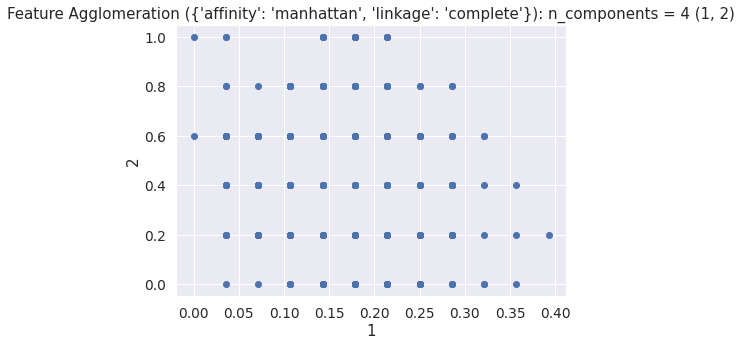

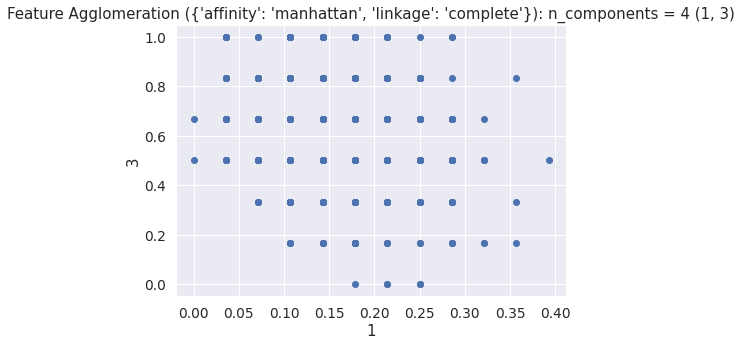

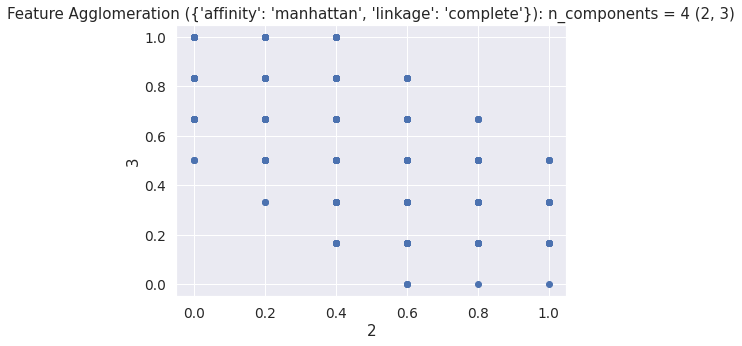

In [39]:
# Feature agglomeration on categorical data - 4 features
X_fa_allCat_4 = compute_and_plot_feature_agglomeration(X_allCat, 4,
                                                       labels=df_allCat.columns,
                                                       kwargs=kwargs_fa_allCat)

   question  feature
2        Q5        0
4        Q7        0
6       Q10        0
7       Q11        0
8       Q12        0
9       Q13        0
10      Q14        0
11      Q15        0
13    Q16=A        0
14    Q16=B        0
15    Q16=C        0
16    Q16=D        0
17    Q17=A        0
18    Q17=B        0
19    Q17=C        0
20    Q17=D        0
21     Q4=A        0
22     Q4=B        0
23     Q4=C        0
24     Q4=D        0
25     Q9=A        0
26     Q9=B        0
27     Q9=C        0
28     Q9=D        0 


   question  feature
0        Q1        1
1        Q3        1
3        Q6        1
5        Q8        1
12      Q18        1 




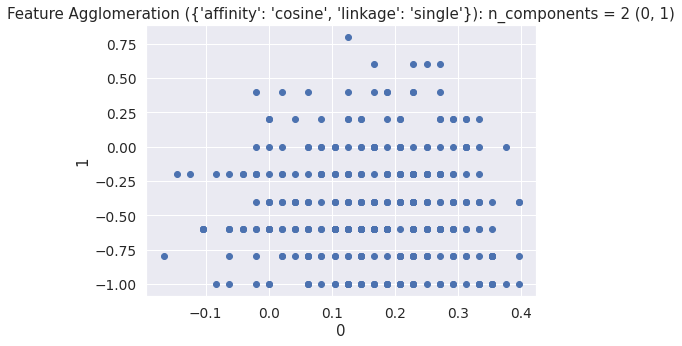

In [40]:
# Feature agglomeration on mixed data - 2 features
X_fa_mixed_2 = compute_and_plot_feature_agglomeration(X_mixed, 2, 
                                                      labels=df_mixed.columns,
                                                      kwargs=kwargs_fa_mixed)

### Clustering/group responses by questions
- Kmeans: imposes equal cluster sizes - don't want that!
- Agglomerative clustering: starts with individual responses and agglomerates responses hierarchically by "distance"

In [41]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Based on scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [42]:
colors = np.array(["#ff0000",
                  "#00ff00",
                  "#0000ff",
                  "#ffff00",
                  "#ff00ff",
                  "#00ffff",
                  "#000000",
                  "#888888",
                  "#ff8800",
                  "#ff0088",
                  "#88ff00",
                  "#00ff88",
                  "#8800ff",
                  "#0088ff",
                  "#ff8888",
                  "#88ff88",
                  "#8888ff",
                  "#880000",
                  "#008800",
                  "#000088",
                  "#888800",
                  "#880088",
                  "#008888",
                  "#444444",
                  "#884400",
                  "#880044",
                  "#448800",
                  "#008844",
                  "#440088",
                  "#004488",
                  "#884444",
                  "#448844",
                  "#444488",
                  "#222222",
                  "#220000",
                  "#002200",
                  "#000022",
                  "#222200",
                  "#220022",
                  "#002222",
                  "#224400",
                  "#220044",
                  "#442200",
                  "#440022",
                  "#002244",
                  "#004422"
                  ])

In [43]:
def run_affinity_propagation(X, kwargs={}, X_for_plotting=None, affinity=None):
    """Perform affinity propagation clustering using precomputed affinity"""
    
    if affinity is None:
        ap = AffinityPropagation()
        ap = ap.fit(X)
        clusters = ap.cluster_centers_
    else:
        assert affinity in ['manhattan', 'cosine'], "Choose one of 'manhattan' or 'cosine' affinity"
        
        ap = AffinityPropagation(affinity='precomputed')
        
        if affinity == 'manhattan':        
            X_distance = manhattan_distances(X)
            X_affinity = np.exp(-X_distance * (1/X.shape[1]))
        elif affinity == 'cosine':
            X_affinity = cosine_similarity(X)
            
        ap = ap.fit(X_affinity)  
        clusters = X[ap.cluster_centers_indices_]
    
    print(f"n_clusters: {len(clusters)}")
    print("number of points in each cluster: ", ", ".join([f"{i}: {str(x)}" for i, x in enumerate(np.bincount(ap.labels_))]))

    if X.shape[1] <= 3:
        scatter_plot_combos(X, X.shape[1], colors=colors[ap.labels_])
    elif X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=colors[ap.labels_])
        
    return clusters, ap

In [44]:
def run_agglomerative_clustering(X, nClusters, kwargs={}, X_for_plotting=None):
    """Run agglomerative clustering"""
    
    ac = AgglomerativeClustering(compute_distances=True,
                                 n_clusters=nClusters,
                                 **kwargs)
    
    ac = ac.fit(X)
    y_predicted = ac.labels_.astype(int)
    print("number of points in each cluster: ", ", ".join([f"{i}: {str(x)}" for i, x in enumerate(np.bincount(ac.labels_))]))

    plt.figure()
    plot_dendrogram(ac, truncate_mode="lastp", p=nClusters) #truncate_mode="level", p=3

    if X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=colors[y_predicted])
    else:
        scatter_plot_combos(X, min(X.shape[1], 3), colors=colors[y_predicted])

##### Cluster original one-hot or ordinal encoded data

----- Affinity propagation -----
Categorical:
n_clusters: 45
number of points in each cluster:  0: 12, 1: 7, 2: 8, 3: 9, 4: 13, 5: 10, 6: 12, 7: 10, 8: 9, 9: 5, 10: 17, 11: 9, 12: 12, 13: 4, 14: 8, 15: 7, 16: 7, 17: 10, 18: 8, 19: 14, 20: 6, 21: 6, 22: 5, 23: 6, 24: 12, 25: 7, 26: 11, 27: 3, 28: 10, 29: 4, 30: 8, 31: 10, 32: 13, 33: 9, 34: 7, 35: 5, 36: 8, 37: 9, 38: 9, 39: 11, 40: 4, 41: 10, 42: 14, 43: 9, 44: 4
Mixed:
n_clusters: 42
number of points in each cluster:  0: 8, 1: 6, 2: 3, 3: 9, 4: 13, 5: 12, 6: 6, 7: 11, 8: 8, 9: 12, 10: 12, 11: 8, 12: 14, 13: 9, 14: 13, 15: 12, 16: 9, 17: 14, 18: 12, 19: 6, 20: 6, 21: 14, 22: 7, 23: 9, 24: 8, 25: 11, 26: 7, 27: 6, 28: 7, 29: 9, 30: 4, 31: 7, 32: 9, 33: 8, 34: 13, 35: 9, 36: 6, 37: 12, 38: 10, 39: 5, 40: 9, 41: 18


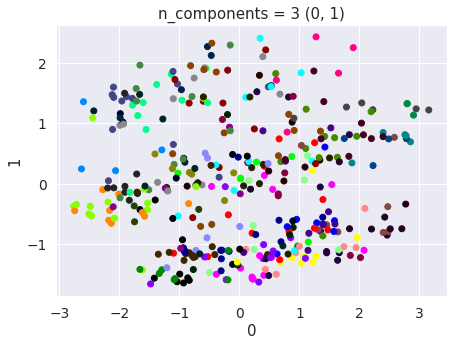

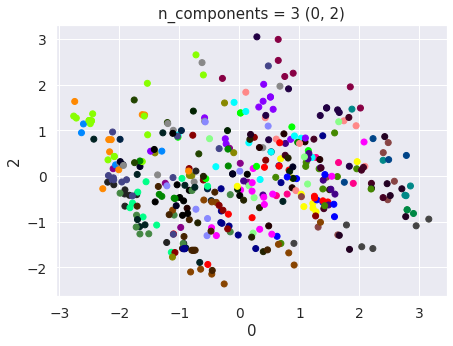

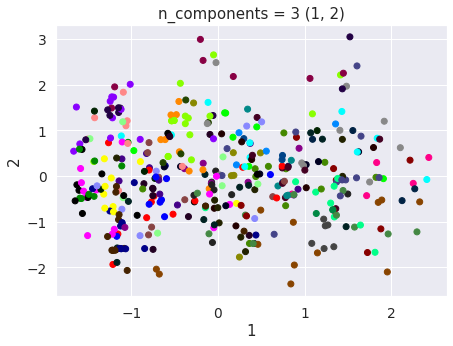

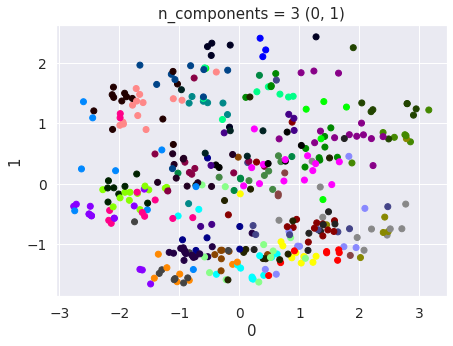

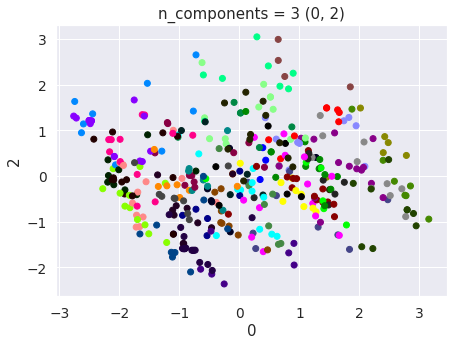

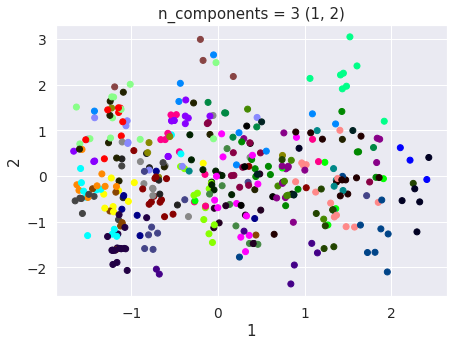

In [45]:
print("----- Affinity propagation -----")
print("Categorical:")
clusters_ap_allCat, ap_allCat = run_affinity_propagation(X_allCat, X_for_plotting=X_pca_mixed, affinity='manhattan')
print("Mixed:")
clusters_ap_mixed, ap_mixed = run_affinity_propagation(X_mixed, X_for_plotting=X_pca_mixed, affinity='cosine')

----- Affinity propagation: clustering on cluster centers... -----
Categorical:
n_clusters: 9
number of points in each cluster:  0: 4, 1: 4, 2: 5, 3: 5, 4: 4, 5: 6, 6: 5, 7: 11, 8: 1
Mixed:
n_clusters: 8
number of points in each cluster:  0: 7, 1: 5, 2: 6, 3: 3, 4: 9, 5: 7, 6: 2, 7: 3


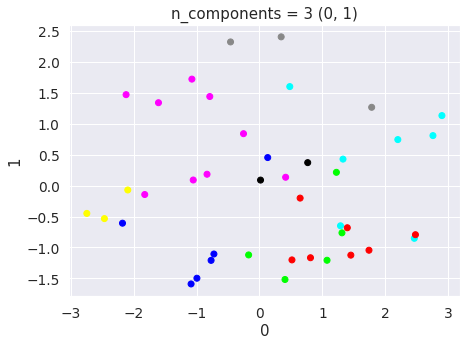

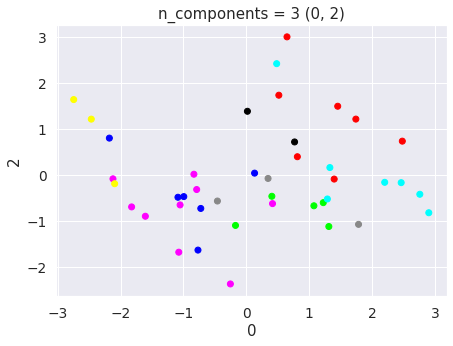

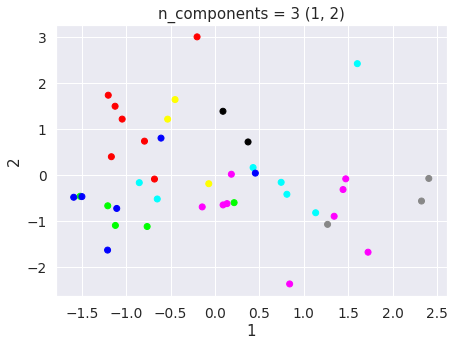

In [46]:
print("----- Affinity propagation: clustering on cluster centers... -----")
print("Categorical:")
clusters_meta_allCat, ap_meta_allCat = run_affinity_propagation(clusters_ap_allCat, affinity='manhattan')
print("Mixed:")
clusters_meta_mixed, ap_meta_mixed = run_affinity_propagation(clusters_ap_mixed,
                             X_for_plotting=pca_result.transform(clusters_ap_mixed),
                             affinity='cosine')

----- Agglomerative clustering -----
Categorical:
number of points in each cluster:  0: 136, 1: 100, 2: 103, 3: 52
Mixed:
number of points in each cluster:  0: 120, 1: 92, 2: 115, 3: 64


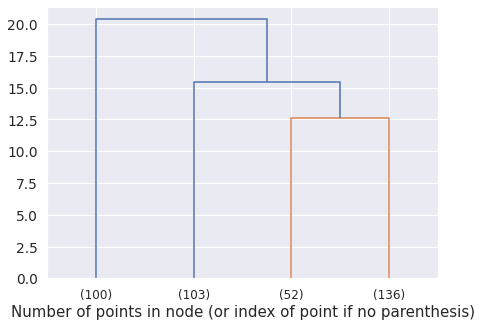

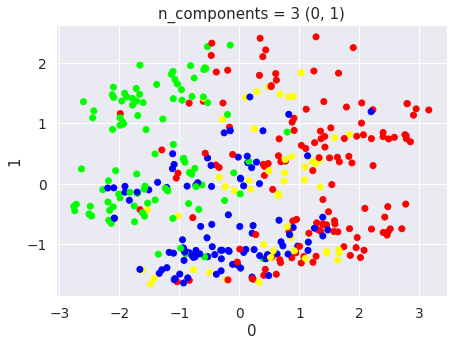

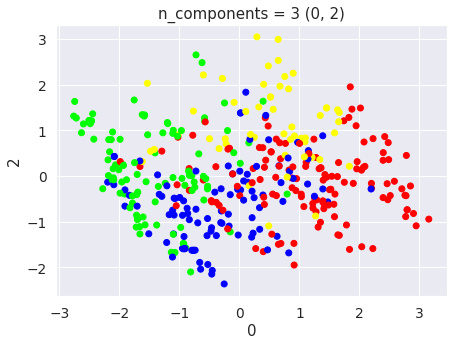

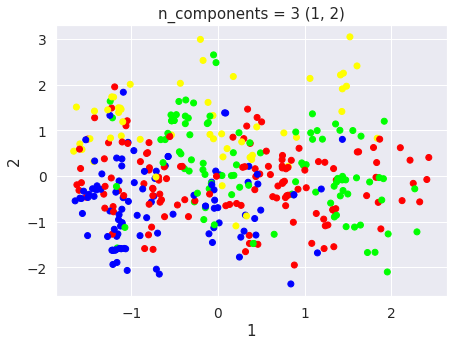

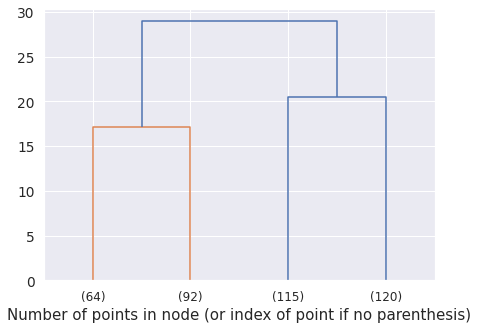

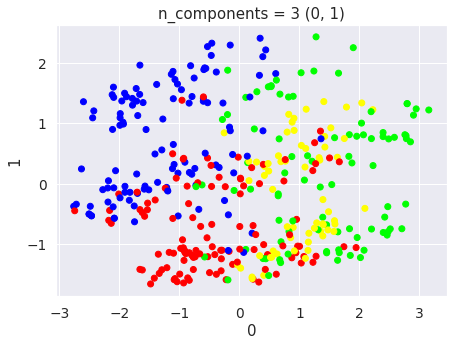

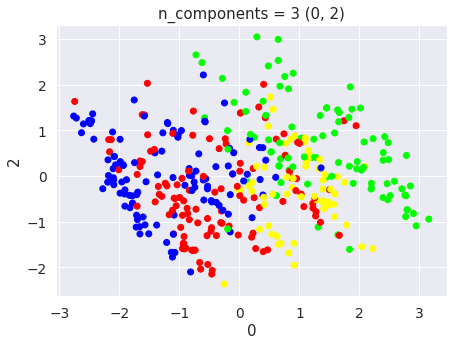

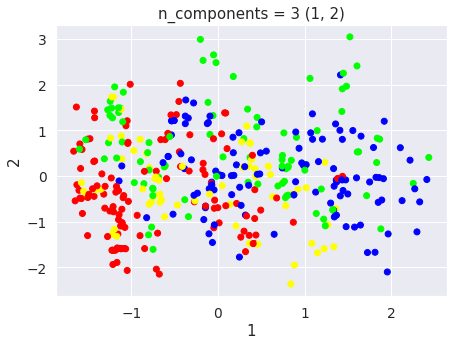

In [47]:
print("----- Agglomerative clustering -----")
print("Categorical:")
run_agglomerative_clustering(X_allCat, 4, X_for_plotting=X_pca_mixed)
print("Mixed:")
run_agglomerative_clustering(X_mixed, 4, X_for_plotting=X_pca_mixed)

##### Cluster lower-dimensional data

If any of the 2D embeddings corresponded to something like the politics-economics axes, we might expect there to be a handful of large clusters and lots of clusters with only a few points (compare w/crosstab). We don't quite observe that.

number of points in each cluster:  0: 98, 1: 122, 2: 97, 3: 74


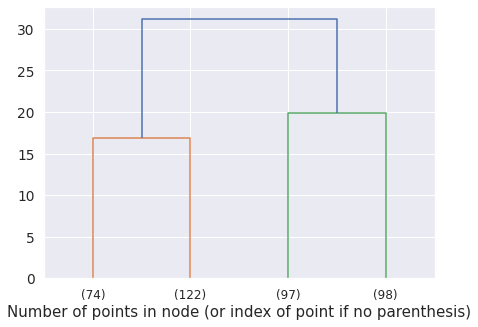

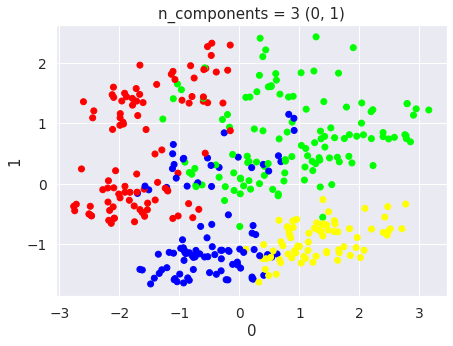

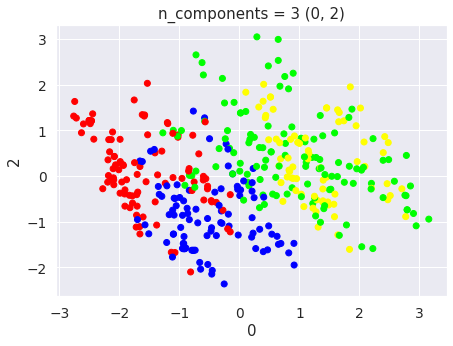

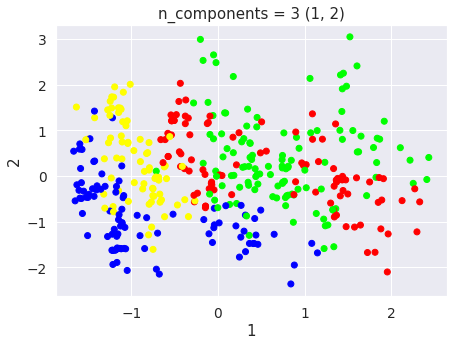

In [48]:
run_agglomerative_clustering(X_pca_mixed[:,:3], 4)

#### First pass: K-means clustering
Since this imposes even cluster sizes, this is probably not a good fit for this data

Two options for this:
1. Treat the data as purely categorical and use [kmodes](https://pypi.org/project/kmodes/) clustering
2. Assign a numerical value to each response (e.g., binary or Likert-scale-like) where possible (though subjective); leave the rest categorical, then use kprototypes clustering

In [49]:
def k_clustering_sweep(responseMatrix, kMax=20, method=KModes, kwargs={}):
    """Find clusters using method (KModes or KPrototype)
    Sweep from k=1 to k=kMax and plot resulting cost to evaluate which k may be most useful"""
    
    costMatrix = []
    kValues = list(np.arange(1, kMax+1))
    clusterCentroids = {}
    for k in range(1, kMax+1):
        # Fit and predict clusters, then save centroids and cost
        clusters = method(n_clusters=k, n_init=20)
        clusters.fit_predict(responseMatrix, **kwargs)
        costMatrix.append(clusters.cost_)
        clusterCentroids[k] = clusters.cluster_centroids_
    
    # Plot result of sweep
    plt.plot(kValues, np.divide(costMatrix, max(costMatrix)))
    plt.xlabel("k")
    plt.ylabel("cost")
    
    return clusterCentroids

### Option 1: categorical only

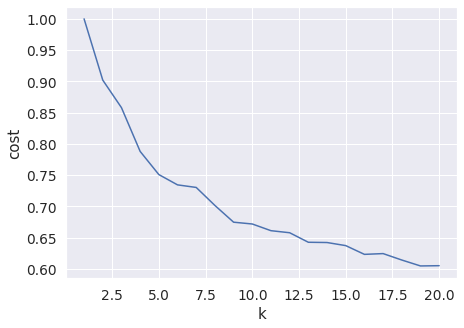

In [50]:
clusterCentroids = k_clustering_sweep(df_to_cluster.to_numpy())

Let's see what the results look like for **6 clusters**:

In [51]:
df_clusters = pd.DataFrame(clusterCentroids[6])
df_clusters

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
1,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
2,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Hard work and determination are no guarantee o...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither
3,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither
4,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Help people around the world earn a living.,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Adapt our technology and practices in order to...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the jobs,Neither
5,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be off-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a c

In [52]:
# Map to integer, just for plotting purposes
df_to_plot = df_clusters.copy()
for col in df_to_plot.columns:
    d = {val: i for (i, val) in enumerate(df_to_plot[col].unique())}
    df_to_plot[col] = df_to_plot[col].map(d)

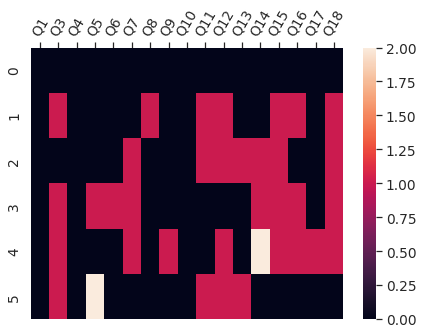

In [53]:
# Plot where centroid value for each question differs between clusters
# If a column is all black, all clusters had the same response.
# If more than one color appears in a column, that number of different responses appeared across clusters.
plt.figure()
fig = sns.heatmap(df_to_plot.astype('float'), cmap=sns.color_palette("rocket", as_cmap=True))
fig.set_xticklabels(labels=cols_questions_clustering, rotation=60)
fig.xaxis.set_ticks_position("top")

### Option 2: mixed categorical and ordinal

In [ ]:
clusterCentroids_mapped = k_clustering_sweep(df_mapped.to_numpy(),
                                             method=KPrototypes,
                                             kwargs={'categorical': [2,7,14,15]})

It's not obvious to me that there's a particularly good number of clusters to stop at. But, to compare with above, let's see what the results look like for **6 clusters**:

In [ ]:
df_cluster_mapped = pd.DataFrame(clusterCentroids_mapped[6])

In [ ]:
# For context, get mapping value ranges for each question involved
# Unfortunately KPrototypes shuffles around column orders a bit, which is annoying...
mappingRange = {q2nDict[k]: (min(v.values()), max(v.values())) for (k, v) in mappingDict.items()}
mappingRangeList = []
question_numbers_ordinal = [1,3,5,6,7,8,10,11,12,13,14,15,18]
for key in question_numbers_ordinal:
    x = mappingRange[key]
    mappingRangeList.append((float(x[0]), float(x[1])))

In [ ]:
# Some pretty printing to keep track of what's happening...
def format_if_float(x):
    try:
        x = float(x)
    except ValueError:
        pass
    
    if isinstance(x, float):
        return f"{x:.2f}"
    else:
        return x
    
print("Range of mapped values for each question:")
pprint.pprint({i: val for (i, val) in enumerate(mappingRangeList)})
print("\nCoordinate of centroid for each question:")
print('\t'.join([str(x) for x in np.arange(1,len(df_cluster_mapped.columns)+1)]))
for i, row in df_cluster_mapped.iterrows():
    print('\t'.join([format_if_float(x) for (j, x) in row.iteritems()]))

In [ ]:
# Plot centroid (roughly, "sentiment") value for each mapped question
# The diverging color palette was chosen so that for values where answers were mapped from -1 to 1
# (indicating opposite opinions), the contrast is clear between red and blue, while for questions
# which were mapped from 0 to 1, the color ranges from neutral white to red.
plt.figure()
fig = sns.heatmap(df_cluster_mapped.iloc[:,:13].astype('float'),
                  cmap=sns.color_palette("vlag", as_cmap=True),
                  vmin=-1, vmax=1)
fig.set_xticklabels(labels=[n2qDict[x] for x in question_numbers_ordinal], rotation=60)
fig.xaxis.set_ticks_position("top")